In [54]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [55]:
def random_normalized(d1, d2):
    x = np.random.random((d1, d2))
    return x / x.sum(axis=1, keepdims = True)


In [56]:
class HMM:
    def __init__(self, M):
        self.M = M # number of hidden states
    
    def fit(self, X, max_iter = 30):
#         np.random.seed(123)
        # train the HMM model using the Baum-Welch algorithm
        # a specific instance of the expectation-maximization algorithm

        # determine V, the vocabulary size
        # assume observables are already integers from 0..V-1
        # X is a jagged array of observed sequences
        
        V = max(max(x) for x in X) + 1 # number of possible observations: from 0 to V-1
        N = len(X) # number of training samples
        
        self.pi = np.ones(self.M) / self.M # initial probability of being in some state
        self.A = random_normalized(self.M, self.M) # transition probability between states
        self.B = random_normalized(self.M, V) # probability of observation given state
        
        print("initial A: {}".format(self.A))
        print("initial B: {}".format(self.B))
        
        costs = []
        
        for it in xrange(max_iter):
            if it % 10 == 0:
                print("it: {}".format(it))
            
            alphas = []
            betas = []
            
            P = np.zeros(N) # probability of each sequence
            
            for n in xrange(N):
                x = X[n]
                T = len(x) # observation duration
                
                alpha = np.zeros((T, self.M))
                alpha[0] = self.pi * self.B[:, x[0]]
                
                for t in xrange(1, T):
                    alpha[t] = alpha[t-1].dot(self.A) * self.B[:, x[t]]
                
                P[n] = alpha[-1].sum()
                alphas.append(alpha)
                
                
                beta = np.zeros((T, self.M))
                beta[-1] = 1
                for t in xrange(T-2, -1, -1):
                    beta[t] = self.A.dot(self.B[:, x[t+1]] * beta[t+1])
                    
                betas.append(beta)
            
            
            assert(np.all(P>0))
            cost = np.sum(np.log(P))
            costs.append(cost)
            
            
            # now re-estimate pi, A, B
            self.pi = np.sum((alphas[n][0] * betas[n][0]) / P[n] for n in xrange(N) ) / N
            
            den1 = np.zeros((self.M, 1))
            den2 = np.zeros((self.M, 1))
            
            a_num = 0
            b_num = 0
            
            
            for n in xrange(N):
                x = X[n]
                T = len(x) # observation duration
                
                den1 += (alphas[n][:-1] * betas[n][:-1]).sum(axis=0, keepdims = True).T / P[n]
                den2 += (alphas[n] * betas[n]).sum(axis=0, keepdims = True).T / P[n]
                
                # numerator for A
                a_num_n = np.zeros((self.M, self.M))
                for i in xrange(self.M):
                    for j in xrange(self.M):
                        for t in xrange(T-1):
                            a_num_n[i,j] += alphas[n][t,i] * self.A[i,j] * self.B[j, x[t+1]] * betas[n][t+1,j]
                            
                a_num += a_num_n / P[n]
            
                # numerator for B
                b_num_n = np.zeros((self.M, V))
                for i in xrange(self.M):
                    for t in xrange(T):
                        b_num_n[i, x[t]] += alphas[n][t,i] * betas[n][t,i]
                                
                b_num += b_num_n / P[n]
                
            self.A = a_num / den1
            self.B = b_num / den2
            
        print("A: {}".format(self.A))
        print("B: {}".format(self.B))
        print("pi: {}".format(self.pi))
        
        plt.plot(costs)
        plt.show()
        
    def likelihood(self, x):
        # returns P(x | model)
        # using the forward part of the forward-backward algorithm
        T = len(x) # observation duration
                
        alpha = np.zeros((T, self.M))
        alpha[0] = self.pi * self.B[:, x[0]]
        
        for t in xrange(1, T):
            alpha[t] = alpha[t-1].dot(self.A) * self.B[:, x[t]]

        return alpha[-1].sum()
    
    def likelihood_multi(self, X):
        return np.array([self.likelihood(x) for x in X])
    
    def log_likelihood_multi(self, X):
        return np.log(self.likelihood_multi(X))
    
    def get_state_sequence(self, x):
        # returns the most likely state sequence given observed sequence x
        # using the Viterbi algorithm
        
        T = len(x)
        
        delta = np.zeros((T, self.M))
        psi = np.zeros((T, self.M))
        
        delta[0] = self.pi * self.B[:, x[0]]
        
        for t in xrange(1,T):
            for j in xrange(self.M):
                delta[t, j] = np.max(delta[t-1]*self.A[:,j]) * self.B[j, x[t]]
                psi[t, j] = np.argmax(delta[t-1]*self.A[:,j])
                
        #backtrack
        states = np.zeros(T, dtype=np.int32)
        
        states[T-1] = np.argmax(delta[T-1])
        
        for t in xrange(T-2, -1, -1):
            states[t] = psi[t+1, states[t+1]]
        
        return states

In [57]:
def fit_coin():
    X = []
    for line in open('coin_data.txt'):
        # 1 for H, 0 for T
        x = [1 if e == 'H' else 0 for e in line.strip()]
        X.append(x)
        
    hmm = HMM(2)
    hmm.fit(X)
    
    L = hmm.log_likelihood_multi(X).sum()
    
    print("Log-Likelihood with fitted parameters: {}".format(L))
    
    print("Best state sequence for {} :".format(X[0]))
    print(hmm.get_state_sequence(X[0]))
    
    hmm.pi = np.array([0.5, 0.5])
    hmm.A = np.array([[0.1, 0.9], [0.8, 0.2]])
    hmm.B = np.array([[0.6, 0.4], [0.3, 0.7]])
    
    TL = hmm.log_likelihood_multi(X).sum()
    print("Log-Likelihood with actual parameters: {}".format(TL))
    
    print("Best state sequence for {} :".format(X[0]))
    print(hmm.get_state_sequence(X[0]))

initial A: [[ 0.46602537  0.53397463]
 [ 0.57693427  0.42306573]]
initial B: [[ 0.32305693  0.67694307]
 [ 0.65294756  0.34705244]]
it: 0
it: 10
it: 20
it: 30
it: 40
it: 50
it: 60
it: 70
it: 80
it: 90
A: [[ 0.2943616   0.7056384 ]
 [ 0.68651349  0.31348651]]
B: [[ 0.28732758  0.71267242]
 [ 0.78737139  0.21262861]]
pi: [ 0.5228034  0.4771966]


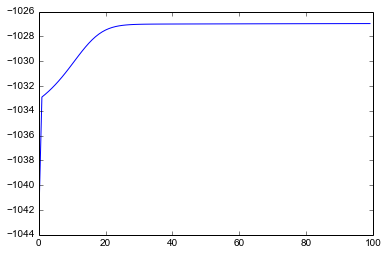

Log-Likelihood with fitted parameters: -1026.96434159
Best state sequence for [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1] :
[1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 0 1 0]
Log-Likelihood with actual parameters: -1059.72291603
Best state sequence for [0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1] :
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [58]:
fit_coin()